In [13]:
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,12)
import pandas as pd
import math
from statsmodels.tsa.seasonal import STL
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

np.random.seed(5)

In [14]:
time_steps = 3
n_features = 1
n_epochs = 60
MODEL = "solo_precio"
DATASET = "papas_g2_pre.csv"


In [15]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [16]:
data = pd.read_csv("../Data/" + MODEL + "/" + DATASET, engine="python")


In [17]:
model = Sequential()
model.add(LSTM(30, input_shape=(time_steps, 3)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

testSets = {}
crops = data["producto"].unique().tolist()
for crop in crops:
    cropData = data[data.producto == crop]["precio_mean"]

    stl = STL(cropData, seasonal=13, period=12)
    res = stl.fit()

    data_trend = res.trend
    data_season = res.seasonal
    data_resid = res.resid

    data_trend = data_trend.values
    data_trend = data_trend.astype('float32')
    data_trend = data_trend.reshape((len(data_trend), 1))

    data_season = data_season.values
    data_season = data_season.astype('float32')
    data_season = data_season.reshape((len(data_season), 1))

    data_resid = data_resid.values
    data_resid = data_resid.astype('float32')
    data_resid = data_resid.reshape((len(data_resid), 1))

    cropPrice = cropData.values
    cropPrice = cropPrice.astype("float32")
    cropPrice = cropPrice.reshape((len(cropPrice), 1))

    dataset = hstack((data_trend, data_season, data_resid, cropPrice))

    train = dataset[0 : int(dataset.shape[0] * 0.8), :]
    test = dataset[int(dataset.shape[0] * 0.8) : len(dataset), :]

    trainX, trainY = split_sequences(train, time_steps)
    testX, testY = split_sequences(test, time_steps)

    model.fit(trainX, trainY, epochs=n_epochs, verbose=2)

    testSets[crop] = {
        "trainX": trainX,
        "trainY": trainY,
        "testX": testX,
        "testY": testY,
        "output": cropPrice,
    }


Epoch 1/60
56/56 - 1s - loss: 0.2131 - 945ms/epoch - 17ms/step
Epoch 2/60
56/56 - 0s - loss: 0.0102 - 59ms/epoch - 1ms/step
Epoch 3/60
56/56 - 0s - loss: 0.0050 - 59ms/epoch - 1ms/step
Epoch 4/60
56/56 - 0s - loss: 0.0025 - 67ms/epoch - 1ms/step
Epoch 5/60
56/56 - 0s - loss: 0.0016 - 68ms/epoch - 1ms/step
Epoch 6/60
56/56 - 0s - loss: 0.0014 - 69ms/epoch - 1ms/step
Epoch 7/60
56/56 - 0s - loss: 0.0013 - 71ms/epoch - 1ms/step
Epoch 8/60
56/56 - 0s - loss: 0.0012 - 69ms/epoch - 1ms/step
Epoch 9/60
56/56 - 0s - loss: 0.0012 - 63ms/epoch - 1ms/step
Epoch 10/60
56/56 - 0s - loss: 0.0011 - 63ms/epoch - 1ms/step
Epoch 11/60
56/56 - 0s - loss: 0.0010 - 67ms/epoch - 1ms/step
Epoch 12/60
56/56 - 0s - loss: 9.7304e-04 - 70ms/epoch - 1ms/step
Epoch 13/60
56/56 - 0s - loss: 9.0010e-04 - 63ms/epoch - 1ms/step
Epoch 14/60
56/56 - 0s - loss: 8.4652e-04 - 59ms/epoch - 1ms/step
Epoch 15/60
56/56 - 0s - loss: 7.8484e-04 - 59ms/epoch - 1ms/step
Epoch 16/60
56/56 - 0s - loss: 7.2632e-04 - 59ms/epoch - 1ms/

14/14 [==============================] - 0s 615us/step
PAPA BLANCA/VALLE/OTROS
Train Score: 0.1488% MAPE
Test Score: 0.1428% MAPE


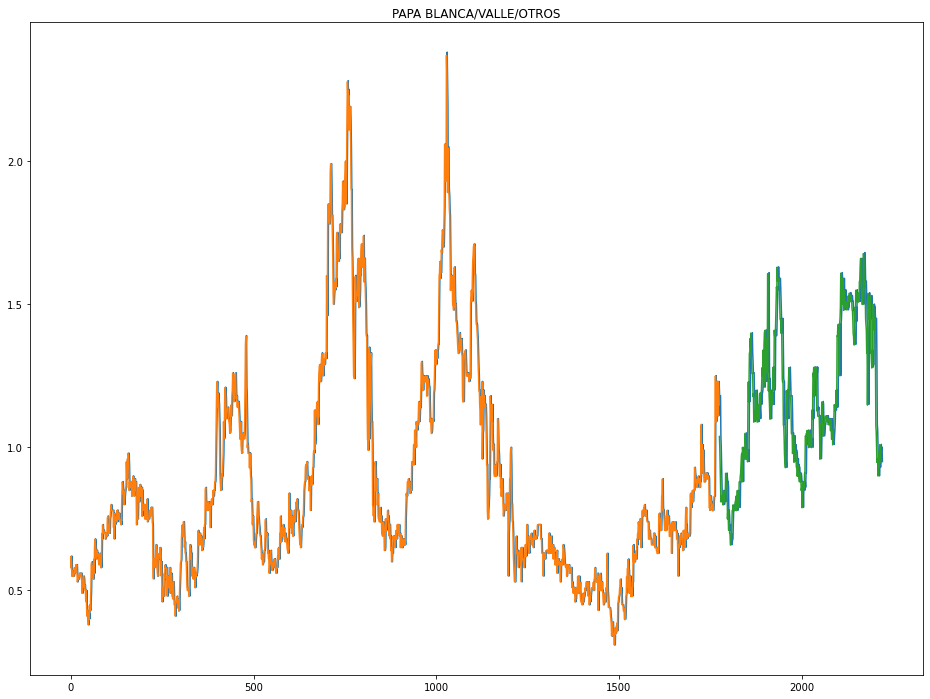

14/14 [==============================] - 0s 615us/step
PAPA COLOR/VALLE/OTROS
Train Score: 0.1410% MAPE
Test Score: 0.1321% MAPE


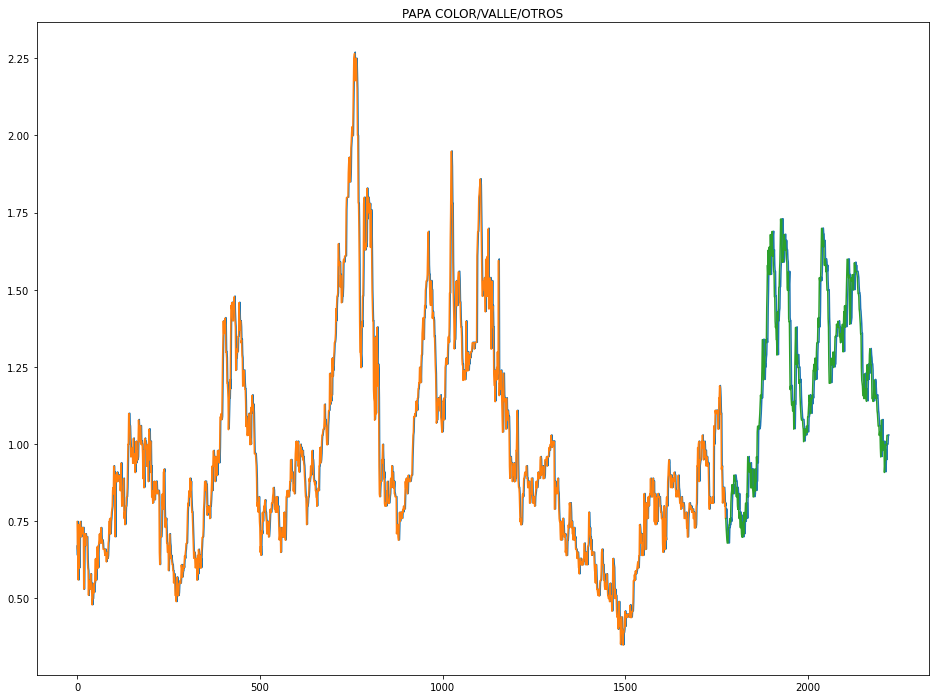

14/14 [==============================] - 0s 654us/step
PAPA NEGRA ANDINA
Train Score: 0.1288% MAPE
Test Score: 0.1208% MAPE


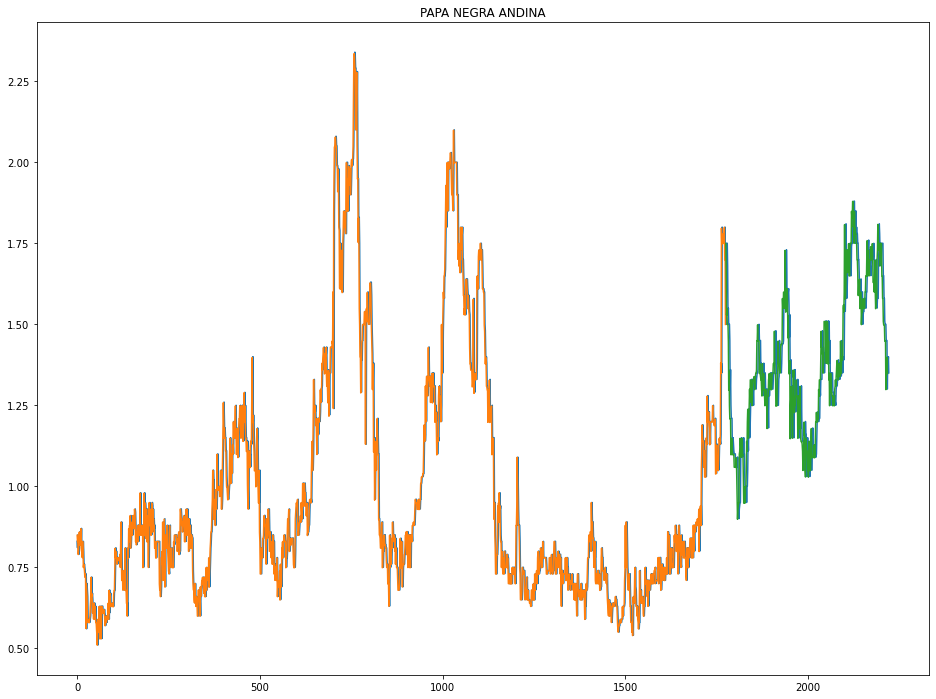

14/14 [==============================] - 0s 692us/step
PAPA YUNGAY
Train Score: 0.1481% MAPE
Test Score: 0.1390% MAPE


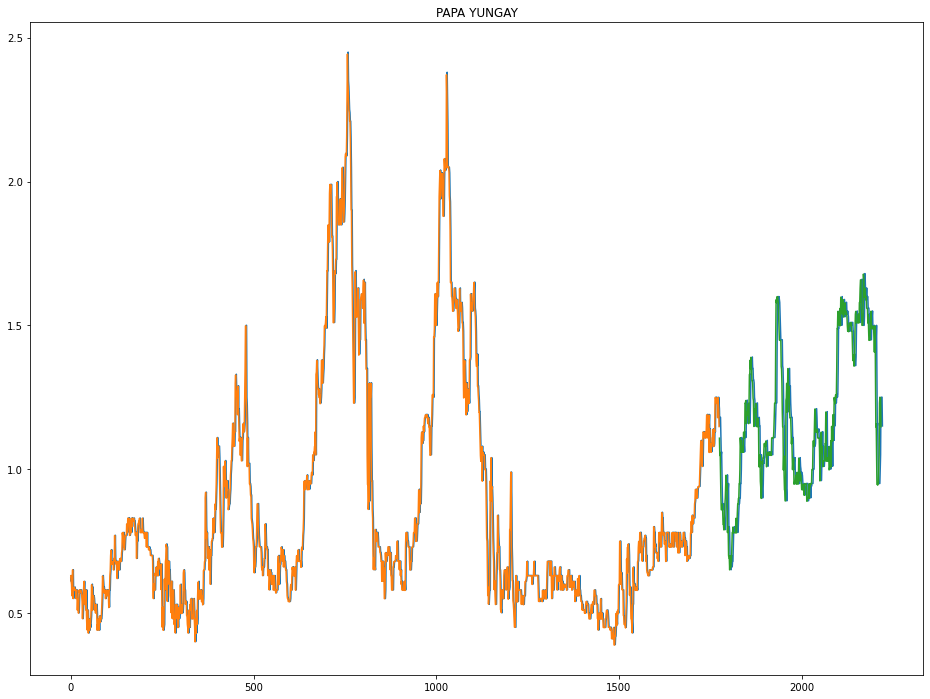

14/14 [==============================] - 0s 654us/step
PAPA UNICA
Train Score: 0.1594% MAPE
Test Score: 0.1316% MAPE


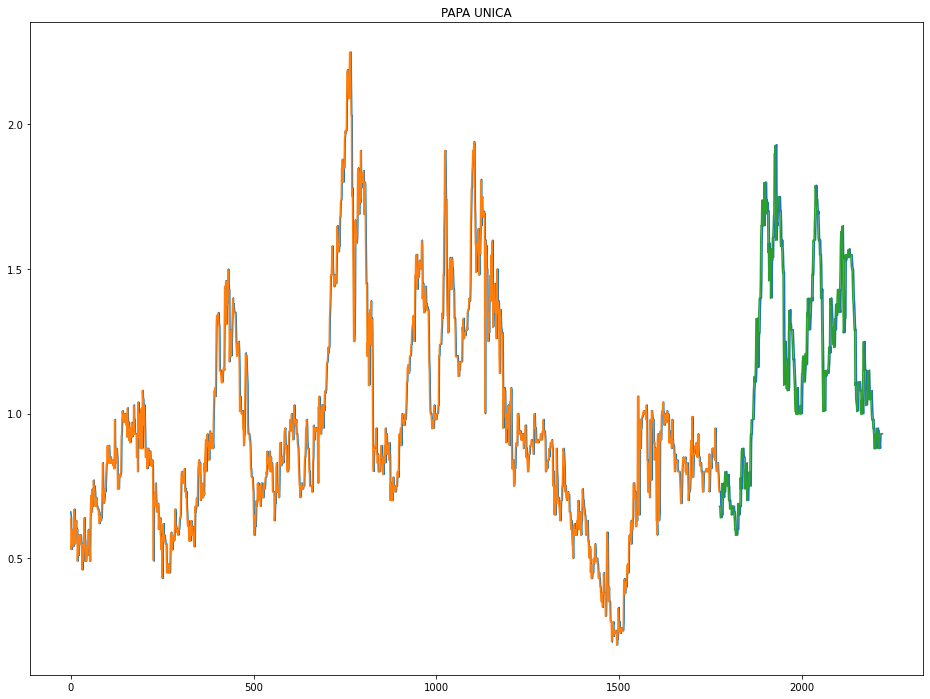

14/14 [==============================] - 0s 654us/step
PAPA CANCHAN
Train Score: 0.1368% MAPE
Test Score: 0.1325% MAPE


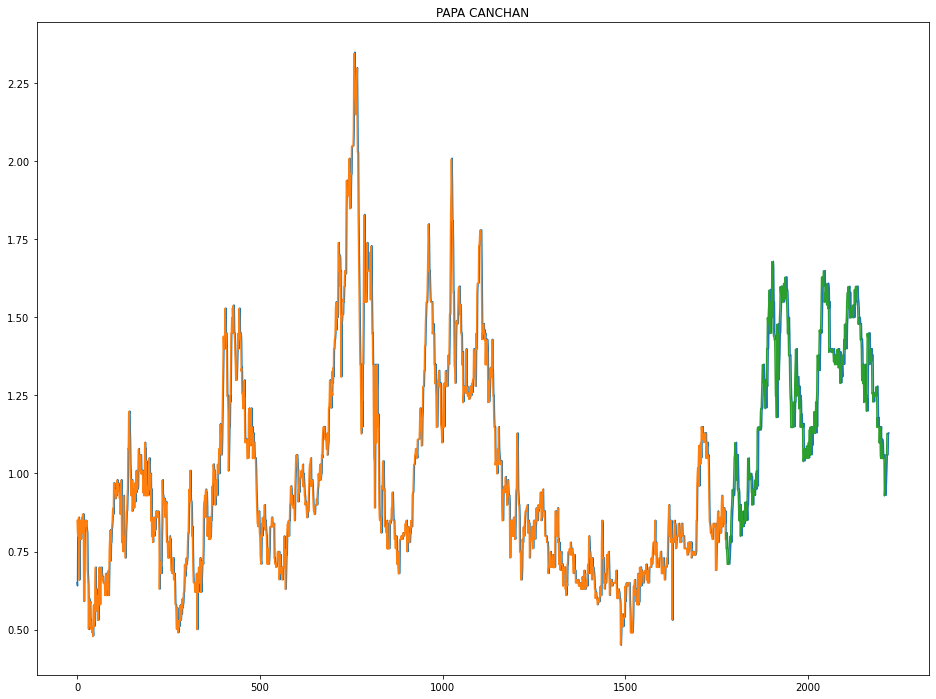

In [18]:
for crop in testSets:
    trainPredict = model.predict(testSets[crop]['trainX'])
    testPredict = model.predict(testSets[crop]['testX'])
    
    print(crop)
    trainScore = mean_absolute_percentage_error(testSets[crop]['trainY'], trainPredict[:,0])
    print('Train Score: %.4f%% MAPE' % (trainScore * 100))
    testScore = mean_absolute_percentage_error(testSets[crop]['testY'], testPredict[:,0])
    print('Test Score: %.4f%% MAPE' % (testScore * 100))

    testPredictPlot = np.empty((len(trainPredict),1,))
    testPredictPlot[:] = np.nan
    testPredictPlot = np.concatenate((testPredictPlot,testPredict))

    plt.title(crop)
    plt.plot(testSets[crop]['output'])
    plt.plot(trainPredict)
    plt.plot(testPredictPlot)
    plt.show()